# Tarea 1 IMA357 (Extracción Automática de Información de la Web y Procesamiento de Lenguaje Natural).
W. Gomez, O. Ayala, S. Nahuelpan

Departamento de Ingeniería Matemática

Universidad de La Frontera

Grupo 4: Jason Ríos, Javier Luengo y Marcos Flores

# Problema 1: (2 puntos)

a) Desde  la sección  "ofertas" del sitio (https://www.kliper.cl/ofertas) guarde una lista de diccionarios con los elementos "producto" , "marca" ,"precio" , "Descripción","descuento" de los primeros 50 articulos . Debe utilizar Selenium para recorrer todas las páginas. 

**Ejemplo:**

        Articulo[0] = {
    
        "Producto" : 'Chaqueta De Pluma 1996 Retro Nuptse Hombre ',

        "Marca" : 'THE NORTH FACE',

        "Precio": 327.990,

        "Descripción" : 'Inspirada por el diseño clásico de nuestra 1996 Nuptse Jacket, esta chaqueta robusta de gran tamaño posee bloques rellenos de pluma de ganso 700. En el cuello podrás guardar la capucha cuando estes lo suficientemente abrigado y cuando no necesites usar la chaqueta, podrás guardarla en uno de sus bolsillos. Ha sido un símbolo global durante décadas. Relajada pero compacta, protectora pero casual, esta es un ícono.':

        "Descuento" : '20%'

        }

b) Coloque en un objeto pandas.Dataframe ordenado por el precio de los articulos de mayor a menor la información de los diccionarios y expórtelo a un archivo .csv con el nombre  `tabla_p1_g4.csv`

c) Subir la tabla al sistema Posgresql en el servidor Khipu con el mismo nombre.


In [2]:
## Inciso 1
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
import time


class Crawler:
    def __init__(self, driver, wait):
        self.driver = driver
        self.wait = wait

    def getPage(self, url):
        """
        Carga una página con Selenium y devuelve un objeto BeautifulSoup.
        """
        try:
            self.driver.get(url)
            time.sleep(2)
            html = self.driver.page_source
        except requests.exceptions.RequestException:
            return None
        return BeautifulSoup(html, 'html.parser')

    def safeGetText(self, bsObj, selector):
        """
        Devuelve el texto del primer elemento que matchee el selector CSS.
        Si no encuentra nada, devuelve cadena vacía.
        """
        childObj = bsObj.select(selector)
        if childObj is not None and len(childObj) > 0:
            return childObj[0].get_text(strip=True)
        return ""

    def limpiar_precio(self, texto):
        """
        Convierte un precio tipo '$327.990' en un entero 327990.
        Si no puede, devuelve None.
        """
        if not texto:
            return None
        
        texto = texto.replace("$", "").replace(".", "").replace("\xa0", "").strip()
        if texto == "":
            return None
        try:
            return int(texto)
        except ValueError:
            return None
    def limpiar_descuento(self, texto):
        """
        Limpia descuentos tipo '-20%' o '-20 %' y devuelve '20%'.
        Si no puede interpretarlo, devuelve None.
        """
        if not texto:
            return None
        
        # Eliminar espacios
        t = texto.strip().replace(" ", "")

        # Debe contener un porcentaje
        if "%" not in t:
            return None

        # Quitar signo negativo si existe
        t = t.replace("-", "")

        # Extraer solo números
        numeros = "".join([c for c in t if c.isdigit()])

        if numeros == "":
            return None

        return numeros + "%"


    def obtener_descripcion(self, url_producto):
        """
        Abre la página de detalle de un producto y extrae la descripción.
        Ajusta los selectores según el HTML real de Kliper.
        """
        bs = self.getPage(url_producto)
        if bs is None:
            return ""

        descripcion = self.safeGetText(
            bs,
            "div.product.attribute.description, div.product.attribute.overview"
        )
        return descripcion

    def extraer_ofertas_kliper(self, max_articulos=50):
        """
        Recorre las páginas de https://www.kliper.cl/ofertas
        y devuelve una lista de diccionarios con los primeros max_articulos.
        """
        base_url = "https://www.kliper.cl/ofertas"
        articulos = []
        pagina = 1

        while len(articulos) < max_articulos:
            url_pagina = f"{base_url}?p={pagina}"
            print(f"\nCargando página de ofertas: {url_pagina}")
            bs = self.getPage(url_pagina)

            if bs is None:
                print("No se pudo cargar la página. Deteniendo.")
                break

            productos = bs.select("ol.products.list.items.product-items li.product-item")
            print(f"Productos encontrados en página {pagina}: {len(productos)}")

            if not productos:
                print("No se encontraron más productos. Fin de la paginación.")
                break

            for prod in productos:
                if len(articulos) >= max_articulos:
                    break

                nombre = self.safeGetText(prod, "a.product-item-link")
                link_tag = prod.select_one("a.product-item-link")

                if not nombre or link_tag is None:
                    continue

                url_producto = link_tag.get("href", "").strip()

                marca = self.safeGetText(
                    prod,
                    "div.product.attribute.marca, div.value"
                )
                
                precio_texto = self.safeGetText(
                    prod,
                    "span.special-price span.price, span.price"
                )
                precio = self.limpiar_precio(precio_texto)

            
                descuento = self.safeGetText(
                    prod,
                    "span.cataloglabel-top-right, div.kliper-label, div.kliper-label__content"
                )
                descuento = self.limpiar_descuento(descuento)

                descripcion = ""
                if url_producto:
                    descripcion = self.obtener_descripcion(url_producto)

                articulo = {
                    "Producto": nombre,
                    "Marca": marca,
                    "Precio": precio,
                    "Descripción": descripcion,
                    "Descuento": descuento
                }

                articulos.append(articulo)
                print(f"Artículo {len(articulos)} agregado: {nombre}")

                if len(articulos) >= max_articulos:
                    break

            pagina += 1

        return articulos

In [3]:
chrome_options = Options()
driver = webdriver.Chrome(options=chrome_options)
wait = WebDriverWait(driver, 10)

crawler = Crawler(driver, wait)

try:
    articulos = crawler.extraer_ofertas_kliper(max_articulos=50)
finally:
    driver.quit()

print(f"\nTotal de artículos extraídos: {len(articulos)}")
print("\nEjemplo Articulo[0]:")
if articulos:
    print(articulos[0])
else:
    print("No se extrajeron artículos.")



Cargando página de ofertas: https://www.kliper.cl/ofertas?p=1
Productos encontrados en página 1: 24
Artículo 1 agregado: Chaqueta De Pluma 1996 Retro Nuptse Hombre
Artículo 2 agregado: Chaqueta De Pluma 1996 Retro Nuptse Hombre
Artículo 3 agregado: ZAPATILLA HOMBRE TRASE SD
Artículo 4 agregado: ZAPATILLAS REEBOK BB 1000
Artículo 5 agregado: Polera Evo Half Dome Mtn Short Sleeve Tee- Graphic Hombre
Artículo 6 agregado: Polera Gap Cuello Alto Sin Manga Mujer
Artículo 7 agregado: ZAPATILLA HOMBRE GIRUN II LOW GTX
Artículo 8 agregado: Zapatos Truckee Mid Mujer
Artículo 9 agregado: Polerón Gap Logo Sin Cierre Hombre
Artículo 10 agregado: POLERÓN HOMBRE MARMOT CHEST LOGO HOODY
Artículo 11 agregado: Camisa Hombre Flannel Solid Regular Sportswear
Artículo 12 agregado: Blusa Gap Eyelet Manga Corta Mujer
Artículo 13 agregado: CHAQUETA HOMBRE MARMOT LONE PINE DOWN
Artículo 14 agregado: Chaqueta De Pluma 1996 Retro Nuptse Mujer
Artículo 15 agregado: ZAPATILLA HOMBRE MANTECA 4
Artículo 16 agregado

In [4]:
## Inciso 2
import pandas as pd

df = pd.DataFrame(articulos)

df_ordenado = df.sort_values(by="Precio", ascending=False)
df_ordenado.head(10)

,Producto,Marca,Precio,Descripción,Descuento
0,Chaqueta De Pluma 1996 Retro Nuptse Hombre,THE NORTH FACE,327990,Inspirada por el diseño clásico de nuestra 199...,20%
13,Chaqueta De Pluma 1996 Retro Nuptse Mujer,THE NORTH FACE,327990,"No hicimos solo una chaqueta acolchada, hicimo...",20%
1,Chaqueta De Pluma 1996 Retro Nuptse Hombre,THE NORTH FACE,286990,Inspirada por el diseño clásico de nuestra 199...,30%
24,Chaqueta De Pluma 1996 Retro Nuptse Mujer,THE NORTH FACE,286990,"No hicimos solo una chaqueta acolchada, hicimo...",30%
41,Chaqueta De Pluma 1996 Retro Nuptse Short Mujer,THE NORTH FACE,230990,La Nuptse ha estado brindando una calidez que ...,30%
48,Chaqueta De Pluma Aconcagua 3 Hoodie Hombre,THE NORTH FACE,173990,Hemos actualizado la aclamada línea Aconcagua ...,40%
25,Chaqueta De Pluma Aconcagua 3 Hombre,THE NORTH FACE,161990,Chaqueta versátil con relleno de pluma que per...,40%
29,ZAPATO HOMBRE ENSI MID GTX,MAMMUT,118990,"Ensi Mid GTX, el zapato perfecto para correr p...",30%
30,ZAPATO MUJER MAMMUT SERTIG II MID GTX,MAMMUT,104990,,50%
36,CHAQUETA INSULADA MUJER ECHO FEATHERLESS,MARMOT,99990,¿Quieres mantenerte cálido sin mucho peso? Pon...,50%


In [5]:
df_ordenado.to_csv("tabla_p1_g4.csv", index=False, encoding="utf-8")

print("El archivo 'tabla_p1_g4.csv' generado correctamente.")

El archivo 'tabla_p1_g4.csv' generado correctamente.


# Problema 2: (2 puntos)

En la siguiente celda se entrega un Crawler modificado de los apuntes vistos en clases, este se utiliza para realizar un raspado de la página "https://www.temuco.cl/".
El raspador debe cumplir con las siguientes especificaciones:

- El usuario ingresa en el constructor de la clase "Crawler", una lista de tópicos (cada grupo tiene una asignada) y un objeto "Website" con elementos HTML.
- El objeto Website ingresado tiene los elementos HTML que permiten al raspador acceder a la barra de búsqueda del sitio, ingresar un tópico, recorrer la lista de resultados y por cada noticia  encontrada (solo noticias!) extraer el título, el cuerpo, la fecha de publicación y la cantidad de parrafos que contiene.
- El raspador debe obtener como máximo 12 noticias por tópico. Se deben obtener al menos 30 noticias en total.
- La clase "Content" tiene un método llamado "cleanContent()" que aplica la función "cleanBodyText()" a la información extraída. La función cleanBodyText() debe eliminar números y símbolos de las cadenas de texto ingresadas siempre y cuando no sean una fecha.
- El método "scrape()" de la clase "Crawler" debe ejecutar el raspado, guardar los resultados en el atributo "dataframe" y exportar a un archivo CSV.

Una vez obtenidos los resultados del raspado, usted deberá:

- Exportar a un archivo .csv con el contenido en las columnas: "topico", "titular", "fecha_publicada", "nr_parrafos", "texto". El nombre del archivo debe indicar el número de grupo  (ej. `cuerpo_documentos_p2_gr_4.csv`)
- Tokenizar los cuerpos obtenidos.
- Vectorizar mediante una bolsa de palabras (BoW) cada documento extraído, el léxico debe corresponder al formado por todos los documentos juntos. Debe eliminar stopwords.
- Crear una matriz (en un arreglo NumPy) de similitudes coseno entre todos los documentos. 
- Para cada documento calcular el promedio de similitudes del mismo con todos los otros documentos y ordenar los documentos de menor a mayor respecto al promedio.
- Indicar ¿Cuál son los titulares de los documentos más y menos representativos del cuerpo en base al promedio de similitud con el resto de los documentos?


Nota:
- La eliminación de stopwords puede realizarla en el proceso que más le acomode (vectorización, tokenización o preprocesamiento).

In [6]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd


import re

def cleanBodyText(body: str) -> str:
    try:
        body = re.sub(r'<figure.*?</figure>', '', body, flags=re.DOTALL)
        body = re.sub(r'https?://\S+\.(?:ogg|mp3|wav|mp4|jpg|png|gif)', '', body)

        body = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]', '', body)

        body = re.sub(r'\s+', ' ', body).strip()
        

        return body
    except Exception as e:
        print(f"Error al limpiar el cuerpo del texto: {e}")
        return body



class Content:
    def __init__(self, topic: str, url: str, title: str, body: str, fecha: str, parrafos: int) -> None:
        self.topic = topic
        self.title = title
        self.body = body
        self.url = url
        self.fecha = fecha  
        self.parrafos = parrafos 
        pass

    def print(self):
        print("Nuevo artículo encontrado para el ITEM: {}".format(self.topic))
        print("TITULO: {}".format(self.title.strip()))
        print("CUERPO: \n{}".format(self.body.strip()))
        print("URL: {}".format(self.url.strip()))
        print("FECHA: {}".format(self.fecha))
        print("CANTIDAD DE PARRAFOS: {}".format(self.parrafos))
        
    
    def cleanContent(self):
        ''' Método que aplica la función de limpieza de texto al título, cuerpo y fechas obtenidas.
        Actúa directamente sobre los atributos.
        '''
        self.title = cleanBodyText(self.title)
        self.body = cleanBodyText(self.body)
        #self.fecha = cleanBodyText(self.fecha)
        pass
    
    
class Website:
    def __init__(self, name: str, url: str, searchUrl: str, resultListing:str ,resultUrl: str, absoluteUrl: bool,
                 titleTag: str, bodyTag: str, fecha: str) -> None:
        self.name = name
        self.url = url
        self.searchUrl = searchUrl # enlace de la barra de búsqueda
        self.resultListing = resultListing  # define el box-cuadro que contiene la información de cada resultado
        self.resultUrl = resultUrl  # define la etiqueta dentro de este box que le dará la URL exacta para el resultado
        self.absoluteUrl = absoluteUrl  # Booleano que indica si los resultados de búsqueda son o no absolutos
        self.titleTag = titleTag
        self.bodyTag = bodyTag
        self.dateTime = fecha  # box con la fecha del contenido seleccionado
        pass


class Crawler:
    
    # Constructor
    def __init__(self, siteData: Website, topics : list):
        """ El constructor recibe Los datos del sitio web y la lista de tópicos. Los atributos de data son ocupados
        al ejecutar los métodos de raspado o de traspaso de resultados a csv.
        """
        self.data = []
        self.siteData = siteData
        self.topics = topics
        self.dataFrame: pd.DataFrame = None
        pass
    
    
    def getPage(self, url) -> BeautifulSoup:
        try:
            req = requests.get(url)
        except requests.exceptions.RequestException:
            return None
        return BeautifulSoup(req.text, 'html.parser')
    

    def safeGet(self, pageObj: BeautifulSoup, selector, contar_parrafos: bool = False):
        childObj = pageObj.select(selector)

        # Nada encontrado
        if not childObj:
            print('Encontrada página sin contenido para el ítem buscado !!')
            if contar_parrafos:
                return '', 0
            else:
                return ''

        # Solo texto simple (sin contar párrafos)
        if not contar_parrafos:
            return '\n'.join([elem.get_text(strip=True) for elem in childObj])

        # Contar párrafos
        textos_parrafos = []
        for elem in childObj:
            txt = elem.get_text(strip=True)
            # Puedes limpiar un poco, pero sin destruir la noción de párrafo
            if txt:
                textos_parrafos.append(txt)

        body = '\n'.join(textos_parrafos)
        parrafos = len(textos_parrafos)

        return body, parrafos



    def search(self, topic: str, site: Website) -> list:
        bs = self.getPage(site.searchUrl + topic)
        searchResults = bs.select(site.resultListing)
        limitador = 0
        datos = []

        for result in searchResults:
            url = result.select(site.resultUrl)[0].attrs["href"]

            if site.absoluteUrl:
                bs_nota = self.getPage(url)
            else:
                bs_nota = self.getPage(site.url + url)

            if bs_nota is None:
                print("Ocurrió algo no deseado. Revisar (método search en Crawler) !!")
                return

            title = self.safeGet(bs_nota, site.titleTag)
            body, parrafos = self.safeGet(bs_nota, site.bodyTag, contar_parrafos=True)
            fecha = self.safeGet(bs_nota, site.dateTime)

            # Filtrar solo noticias por categoría
            categoria = result.select('td a span[data-slug]')
            if categoria:
                categoria_texto = categoria[0].get_text().strip()
            else:
                categoria_texto = ''

            if title != '' and body != '' and categoria_texto.lower() == 'noticias':
                content = Content(topic=topic, url=url, title=title,
                                body=body, fecha=fecha, parrafos=parrafos)
                content.cleanContent()
                content.print()
                print('--------------------------------------------------------------')
                datos.append(content)
                limitador += 1
                if limitador >= 12:
                    break

        return datos

    

    def to_CSV(self):
        Data = [contenido for topico in self.data for contenido in topico]
        DataDict = {
            "Topico": [content.topic for content in Data],
            "Titular": [content.title for content in Data],
            "Cuerpo": [content.body for content in Data],
            "Fecha_Publicada": [content.fecha for content in Data],
            "N_Parrafos": [content.parrafos for content in Data]
        }
        
        self.dataFrame = pd.DataFrame(data=DataDict)
        self.dataFrame['Topico'] = self.dataFrame['Topico'].astype('string')
        self.dataFrame['Titular'] = self.dataFrame['Titular'].astype('string')
        self.dataFrame['Cuerpo'] = self.dataFrame['Cuerpo'].astype('string')
        self.dataFrame['Fecha_Publicada'] = self.dataFrame['Fecha_Publicada'].astype('string')
        
        self.dataFrame.to_csv('cuerpo_documentos_p2_gr_4.csv', index=False)

        pass


    def scrape(self):
        """ Este método se encarga de ejecutar todo lo necesario para el raspado, construir el dataFrame de pandas y el csv.
        """
        for topic in self.topics:
            print("BUSCANDO INFORMACION SOBRE: " + topic)
            self.data.append(self.search(topic=topic,site=self.siteData))
        self.to_CSV()  # Crear DataFrame y CSV.
        pass

In [7]:
topicos = ['violencia','turismo','rural']  # Grupo 4

In [8]:
# Identificar elementos del HTML.
siteData = Website(name='temuco',
                    url='https://www.temuco.cl/',
                    searchUrl='https://www.temuco.cl/?s=',
                    resultListing='tr.post-row',
                    resultUrl='td a',
                    absoluteUrl=True, 
                    titleTag='h1.entry-title',
                    bodyTag='div.entry-content p',
                    fecha= 'time')

crawler = Crawler(siteData=siteData,topics=topicos)
crawler.scrape()

BUSCANDO INFORMACION SOBRE: violencia
Nuevo artículo encontrado para el ITEM: violencia
TITULO: Temuco refuerza la seguridad en sus centros de salud con una inversión de más de millones anuales desde el
CUERPO: 
Tras el reciente hecho de violencia ocurrido en las dependencias del Cesfam Amanecer se activaron los protocolos de emergencia y se prestó apoyo inmediato a todo el equipo para mitigar las consecuencias de lo sucedido El pasado de noviembre alrededor de las horas un individuo ingresó al centro de salud familiar con una herida en la cabeza Mientras el personal de salud le brindaba atención tres personas llegaron al lugar amenazando y agrediendo nuevamente al afectado El episodio generó pánico entre las y los usuarios presentes y en el equipo de salud debido al alto nivel de violencia Ante esta situación desde el Departamento de Salud Municipal recordaron episodios similares y destacaron la activación de los protocolos así como los resguardos implementados desde para proteger a q

In [9]:
crawler.dataFrame.head()  # Ver últimos resultados

,Topico,Titular,Cuerpo,Fecha_Publicada,N_Parrafos
0,violencia,Temuco refuerza la seguridad en sus centros de...,Tras el reciente hecho de violencia ocurrido e...,7 de noviembre de 2025,15
1,violencia,En pocas horas patrulleros municipales de Temu...,En un patrullaje rutinario funcionarios de la ...,3 de noviembre de 2025,5
2,violencia,Operativos simultáneos del municipio despejan ...,La Municipalidad de Temuco en coordinación con...,17 de octubre de 2025,8
3,violencia,Contactó a la víctima por Facebook patrullaje ...,La rápida respuesta de los inspectores municip...,16 de octubre de 2025,6
4,violencia,Cámara aprueba proyecto Ley Insuco que permite...,Tras la aprobación del proyecto en la Cámara d...,16 de octubre de 2025,6


In [10]:
# Tokenización y vectorización
import math
import copy
from collections import Counter, OrderedDict
import nltk
from nltk import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

def tokenizar(texto):
    tokenizer = RegexpTokenizer(r'\w+|\S+')
    tokens = tokenizer.tokenize(texto)
    #print(f"Tokens iniciales: {len(tokens)}")
    
    stop_words_spanish = nltk.corpus.stopwords.words('spanish')
    stop_words_english = nltk.corpus.stopwords.words('english')
    stop_words = ['!', '.', '¿', '?', '¡', ';', '(', ')','-','--',':','"',"'",","]
    palabras_feas = stop_words + stop_words_spanish + stop_words_english
    tokens = [x for x in tokens if x not in palabras_feas]
    #print(f"Tokens después de eliminar StopWords: {len(tokens)}")

    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t).strip("'") for t in tokens]

    tokens = sorted(set(tokens))
    #print(f"Tokens después de eliminar elementos repetidos: {len(tokens)}")
    
    return tokens

def BoW_vec(docs: list):
    doc_tokens = []
    for doc in docs:
        tokens = tokenizar(doc.lower())
        ##
        ##
        ##
        doc_tokens += [sorted(tokens)]
    all_doc_tokens = sum(doc_tokens, [])
    lexico = sorted(set(all_doc_tokens))
    zero_vector = OrderedDict((token, 0) for token in lexico)
    document_bow_vectors = []
    for i, doc in enumerate(docs):
        vec = copy.copy(zero_vector)
        tokens = tokenizar(doc.lower())
        ##
        ##
        ##
        token_counts = Counter(tokens)
        for key, value in token_counts.items():
            vec[key] = value
        document_bow_vectors.append(vec) 
    return document_bow_vectors

document_BoW_vector = BoW_vec(docs=crawler.dataFrame['Cuerpo'].to_list())

In [11]:
# Calcular matriz de semejanza
import numpy as np

def sim_coseno(vec1, vec2):
    vec1 = [val for val in vec1.values()]
    vec2 = [val for val in vec2.values()]
    dot_prod = 0
    for i, v in enumerate(vec1):
        dot_prod += v * vec2[i]
    norm_1 = math.sqrt(sum([x**2 for x in vec1]))
    norm_2 = math.sqrt(sum([x**2 for x in vec2]))
    return dot_prod / (norm_1 * norm_2)

In [12]:
# Crear matriz de similitudes coseno.
matriz_semejanza = np.zeros((len(document_BoW_vector),len(document_BoW_vector)))  # Crear matriz de ceros

# en cada posición de la matriz i,j coloque la similitud coseno entre el documento i y j.
n_docs = len(document_BoW_vector)
for i in range(n_docs):
    for j in range(n_docs):
        matriz_semejanza[i, j] = sim_coseno(document_BoW_vector[i], document_BoW_vector[j])

In [13]:
np.set_printoptions(precision=2, suppress=True)
print(matriz_semejanza)

[[1.   0.16 0.19 ... 0.13 0.18 0.19]
 [0.16 1.   0.21 ... 0.12 0.08 0.09]
 [0.19 0.21 1.   ... 0.23 0.18 0.18]
 ...
 [0.13 0.12 0.23 ... 1.   0.17 0.13]
 [0.18 0.08 0.18 ... 0.17 1.   0.2 ]
 [0.19 0.09 0.18 ... 0.13 0.2  1.  ]]


In [14]:
promedios = matriz_semejanza.mean(axis=1) 
indices_ordenados = np.argsort(promedios)
titulares_ordenados = crawler.dataFrame['Titular'].iloc[indices_ordenados].to_list()
for idx in indices_ordenados:
    titular = crawler.dataFrame['Titular'].iloc[idx]
    prom = promedios[idx]
    print(f"{idx} — {titular}  (promedio={prom:.4f})")

3 — Contactó a la víctima por Facebook patrullaje municipal en Temuco permite detener a violento sujeto que golpeó y robó zapatillas a un adolescente  (promedio=0.1491)
1 — En pocas horas patrulleros municipales de Temuco hallan en toma un vehículo que estaría vinculado a violento asalto  (promedio=0.1527)
14 — Temuco Vibra presenta la obra Ecos de un caminante onírico  (promedio=0.1627)
33 — Comunicado de Prensa Cambios en el equipo directivo municipal  (promedio=0.1677)
10 — Municipio refuerza control en espacios públicos tomados por okupas en el centro de Temuco  (promedio=0.1696)
34 — En un hito significativo para la comunidad mapuche Juan Cayul siete familias del sector rural de Renanco recibieron las llaves de sus nuevas viviendas definitivas  (promedio=0.1730)
6 — Patrullaje preventivo municipal en Temuco facilita detención de delincuente que era requerido por la justicia de Concepción  (promedio=0.1736)
5 — Carabineros detiene a sujeto que amenazó de muerte a inspector municipa

In [23]:
doc_menos_representativo = titulares_ordenados[0]
doc_mas_representativo = titulares_ordenados[-1]

# Mostrar resultados
print("Documento menos representativo:\n------------------------------------\n",indices_ordenados[0],"-", doc_menos_representativo)
print("\nDocumento más representativo:\n------------------------------------\n",indices_ordenados[-1],"-" ,doc_mas_representativo)

Documento menos representativo:
------------------------------------
 3 - Contactó a la víctima por Facebook patrullaje municipal en Temuco permite detener a violento sujeto que golpeó y robó zapatillas a un adolescente

Documento más representativo:
------------------------------------
 27 - Temuco certifica a nuevas orfebres mapuche Un impulso para la identidad y desarrollo rural


# Problema 3: (2 puntos)


a) Crear un repositorio en Github con el nombre "Repositorio_IMA_357_2025_2_Grupo_4". El repositorio debe contener el archivo  `cuerpo_documentos_p2_gr_4.csv` creado en la pregunta anterior y un archivo .py (para resolver el siguiente inciso) con su correspondiente archivo de requerimientos. 

b) Implementar una aplicación en streamlit que tenga las siguientes funcionalidades:

* Acceder al repositorio de GitHub, cargar el archivo `cuerpo_documentos_p2_gr_4.csv` obtenido del raspado de datos en la pregunta anterior y mostrar su contenido en una tabla.
* Contener dos inputs de texto, uno que recibe una palabra (`Input de palabra`) y otro que recibe una oración (`Input de oración`). 
* Al ingresar una palabra en el `Input de palabra` se identifica el documento del archivo cargado que contiene la mayor frecuencia de la palabra ingresada. Se debe mostrar entonces el titular del documento identificado y la frecuencia de la palabra ingresada en dicho documento.
* Al ingresar una oración en el `Input de oración` se deben identificar dos elementos:
  - El párrafo de alguno de los documentos del cuerpo que sea más similar a la oración ingresada respecto a la similitud coseno.
  - El documento del cuerpo con la mayor suma de frecuencias de tokens de la oración ingresada. Un ejemplo de la suma de frecuencias es el siguiente:

      `Ejemplo:`
      
      Si el documento es: `Cierta universidad se encuentra en una terrible crisis financiera`
      
      y la oración es: `terrible universidad aquella`, 
      
      entonces la salida debe ser 1+1+0 = 2 (pues "terrible" y "universidad" aparecen ambas 1 vez).

* Para el párrafo más similar respecto a la similitud coseno se debe mostrar el titular del documento correspondiente, el tópico asociado y el valor de la similitud coseno calculada.
* Para el documento con la mayor suma de frecuencias se debe mostrar el titular del documento correspondiente, el tópico asociado y el valor encontrado para la suma de frecuencias de cada token de la oración. 


#### Observación: Los entregables del problema 3 serían:

  - un link con la implementación de la app en Streamlit.  (Revisar el siguiente link con instrucciones del procedimiento: https://docs.streamlit.io/deploy/streamlit-community-cloud/deploy-your-app)
  - un link al repositorio de GitHub que contiene el archivo de requerimientos, el .py (su script para la app) y  el archivo `cuerpo_documentos_p2_gr_4.csv`.
  


#### Ejemplo de salida de una aplicación en streamlit con funcionalidad similar a la solicitada.

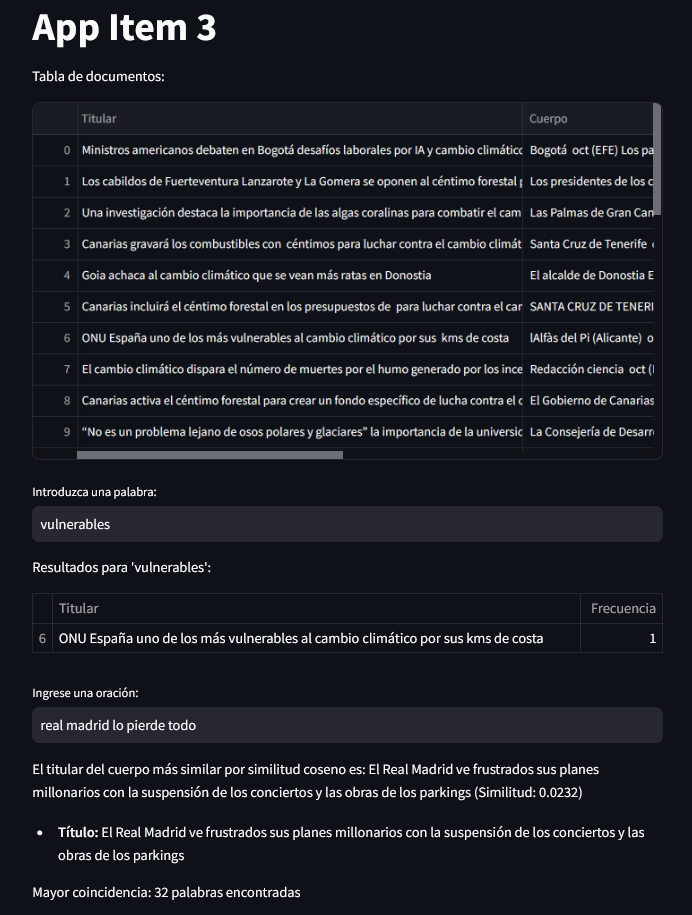

In [ ]:
from IPython.display import Image

Image(filename="Ejemplo_item_3.png",width=600)